In [33]:
import math
import torch
import random

In [48]:
class Value:
    
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda : None
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')
        def back():
            self.grad += out.grad 
            other.grad += out.grad
            self._backward()
            other._backward()
        out._backward = back
        
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')
        
        def back():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            self._backward()
            other._backward()
        out._backward = back
        
        return out 
    
    def __radd__(self, other): # other + self
        return self + other

    
    def __rmul__(self,other):
        return self * other
    
    def __pow__(self,other):

        out = Value(self.data**other,(self,),f'**{other}')
        
        def back():
            self.grad *= other*(self.data**(other-1)) 
            self._backward()
        out._backward = back
    
    def __truediv__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        return self * other.data**-1

    def __neg__(self):
        return self * -1.0

    def __sub__(self,other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        
        def back():
            self.grad += (1-t**2) * out.grad
            self._backward()
        out._backward = back
        
        return out
    
    def exp(self):
        out = Value(math.exp(self.data),(self,),'exp')
        
        def back():
            self.grad += out.data
            self._backward()
        out._backward = back
    
    def backward(self):
        self.grad = 1.0
        self._backward()
    

In [14]:
from graphviz import Digraph

def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})
    nodes,edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid,label=f'%s | Data %.4f | Grad %.4f'%(n.label,n.data,n.grad),shape='record')
        if n._op:
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid+n._op,uid)
            
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
        
    return dot

In [111]:
def lol():
    h = 0.0001
    
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2,label='f') 
    l = d*f;l.label = 'l'
    l1 = l.data 
    
    a = Value(2.0+h,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2,label='f') 
    l = d*f;l.label = 'l'
    l2 = l.data
    
    print((l2-l1)/h)

lol()

6.000000000021544


In [21]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

b = Value(6.881373587,label='b')

x1w1 = x1*w1;x1w1.label='x1*w1'
x2w2 = x2*w2;x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b;n.label='n'
o = n.tanh();o.label = 'o'

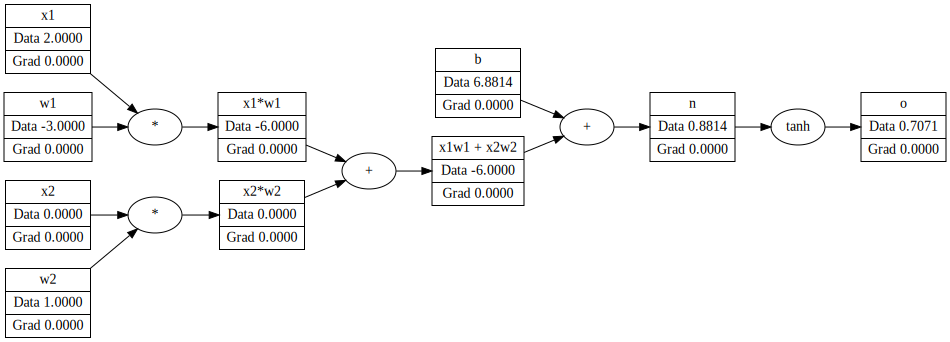

In [22]:
draw_dot(o)

In [23]:
o.backward()

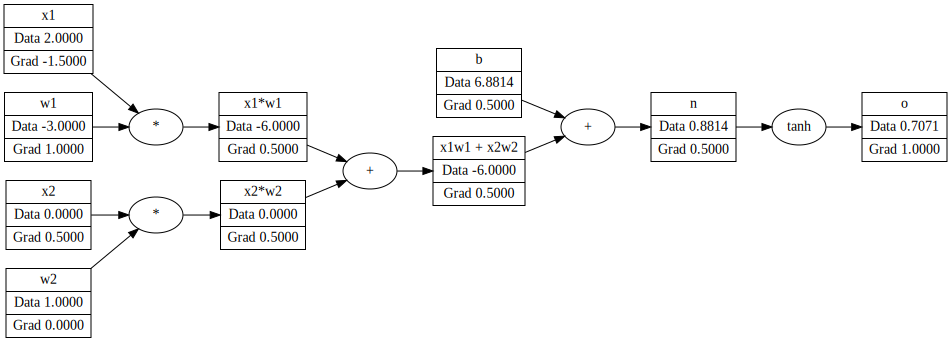

In [24]:
draw_dot(o)

In [31]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True 
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b 
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())

0.7071066904050358
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [64]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum((wi*xi for xi,wi in zip(x,self.w)),self.b)
        out = act.tanh()
        return out
    
x = [2.0,3.0]
n = Neuron(2)
n(x)

Value(data=-0.686811750853281)